In this notebook we will test the column selection module 

In [1]:
# IMPORTs
from utils.task import Task
import json
import os
from src.pipeline.column_selection import column_selection
from utils.database_utils.db_info import get_db_schema
from tqdm import tqdm
from dotenv import load_dotenv
from utils.sql_query_parsers import get_sql_columns_dict
import matplotlib.pyplot as plt
import numpy as np
from utils.prompt import load_prompt
import tiktoken

load_dotenv()

True

In [2]:
# Function to load JSON data
def load_json_data(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
    return data


# Function to create task object
def create_task(example):
    return Task(example)

In [3]:
# load the task data
filepath = "C:/Users\yousf\Bureau\ConvergenceAI\CHESS_Impl\data/test/subsampled_test.json"
data = load_json_data(filepath)
# load the retrieved entities
filepath_entities = "C:/Users\yousf\Bureau\ConvergenceAI\CHESS_Impl\data/test/retrieved_entities.json"
retrieved_entities = load_json_data(filepath_entities)
# load the retrieved context
filepath_context = "C:/Users\yousf\Bureau\ConvergenceAI\CHESS_Impl\data/test/retrieved_context.json"
retrieved_context = load_json_data(filepath_context)
# load the tentative schema
filepath_schema = "C:/Users\yousf\Bureau\ConvergenceAI\CHESS_Impl\data/test/tentative_schema.json"
tentative_schema = load_json_data(filepath_schema)


In [4]:
# test column selection module with a random sample
index = 1
example = data[index]
task = create_task(example)

#get the database schema
dp_path = os.getenv("DB_ROOT_PATH") + f"/{task.db_id}/{task.db_id}.sqlite"
schema = get_db_schema(dp_path)
model = "llama-3"
ans = column_selection(task=task, retrieved_entities=retrieved_entities[index],
                       retrieved_context=retrieved_context[index], tentative_schema=schema, model=model, num_samples=1)
ans

You are an SQL expert and very smart data analyst.
Your task is to examine the provided database schema, understand the posed question, and use the hint to pinpoint the specific columns within tables that are essential for crafting a SQL query to answer the question.

Database Schema Overview:
CREATE TABLE frpm
(
	CDSCode TEXT not null primary key,
	`Academic Year` TEXT null, --
	`County Code` TEXT null, -- examples: `02`
	`District Code` INTEGER null, --
	`School Code` TEXT null, -- description: School Code
	`County Name` TEXT null, -- examples: `Merced`
	`District Name` TEXT null, --
	`School Name` TEXT null, --
	`District Type` TEXT null, --
	`School Type` TEXT null, --
	`Educational Option Type` TEXT null, --
	`NSLP Provision Status` TEXT null, -- examples: `Provision 2`, `Lunch Provision 2`
	`Charter School (Y/N)` INTEGER null, --
	`Charter School Number` TEXT null, --
	`Charter Funding Type` TEXT null, --
	IRC INTEGER null, --
	`Low Grade` TEXT null, --
	`High Grade` TEXT null, -

{'selected_schema': {'frpm': ['CDSCode',
   'County Name',
   'Low Grade',
   'High Grade',
   'NSLP Provision Status'],
  'schools': ['CDSCode', 'City', 'EILCode', 'County']},
 'chain_of_thought_reasoning': "The question asks for the city location of a high school level school with Lunch Provision 2, lowest grade 9, and highest grade 12 in the county of Merced. The hint suggests that EILCode = 'HS' represents high school. We need to identify the school with this characteristic and then find its city location. We can filter the schools based on EILCode, County, Low Grade, and High Grade. We also need to join the frpm and schools tables to get the city location."}

In [4]:
#test column selection module with the subsampled test and with the base schema of database
model = "gpt-4"
num_samples = 1
res = []
for index, sample in tqdm(enumerate(data)):
    task = create_task(sample)
    dp_path = os.getenv("DB_ROOT_PATH") + f"/{task.db_id}/{task.db_id}.sqlite"
    schema = get_db_schema(dp_path)

    ans = column_selection(task=task, retrieved_entities=retrieved_entities[index],
                           retrieved_context=retrieved_context[index], tentative_schema=schema, model=model,
                           num_samples=num_samples)
    res.append(ans)
    print(str(index) + " : ", ans)

1it [00:06,  6.27s/it]

0 :  {'selected_schema': {'atom': ['atom_id', 'molecule_id'], 'bond': ['bond_type', 'molecule_id']}, 'chain_of_thought_reasoning': "To answer the question, we need to identify atoms that belong to the molecule 'TR346' and count the distinct types of bonds that can be created by this molecule. The 'atom' table is used to filter atoms by 'molecule_id' to find those belonging to 'TR346'. The 'bond' table is used to count distinct 'bond_type' for the molecule 'TR346'. The 'molecule_id' column in both 'atom' and 'bond' tables is crucial for filtering data specific to 'TR346'. The 'atom_id' column in the 'atom' table is necessary to list the atoms, and the 'bond_type' column in the 'bond' table is needed to count the types of bonds."}


2it [00:12,  6.43s/it]

1 :  {'selected_schema': {'schools': ['CDSCode', 'County', 'EILCode', 'City'], 'frpm': ['CDSCode', 'NSLP Provision Status', 'Low Grade', 'High Grade']}, 'chain_of_thought_reasoning': "To answer the question, we need to identify a high school in the county of Merced that offers Lunch Provision 2, with the lowest grade being 9 and the highest grade being 12. We use the 'schools' table to filter by county and to ensure the school is a high school using the EILCode. The 'frpm' table is used to filter schools based on the NSLP Provision Status for Lunch Provision 2 and to ensure the grade span matches the requirements. The 'City' column from the 'schools' table is necessary to determine the city location of the school."}


3it [00:20,  6.96s/it]

2 :  {'selected_schema': {'superhero': ['id', 'full_name', 'height_cm', 'publisher_id'], 'publisher': ['id', 'publisher_name']}, 'chain_of_thought_reasoning': "To find the tallest hero published by Marvel Comics, we need to identify the hero with the maximum height from the publisher 'Marvel Comics'. We need the 'height_cm' from the superhero table to determine the tallest hero. The 'publisher_name' from the publisher table is required to filter heroes by the publisher 'Marvel Comics'. The 'full_name' from the superhero table is necessary to provide the full name of the tallest hero. The 'publisher_id' in the superhero table and 'id' in the publisher table are needed to join these tables on the correct publisher."}


4it [00:28,  7.50s/it]

3 :  {'selected_schema': {'badges': ['UserId', 'Name'], 'users': ['Id', 'Age']}, 'chain_of_thought_reasoning': "To determine how many elders obtained the 'Supporter' badge, we need to identify users who are elders (Age > 65) and have received the 'Supporter' badge. We start by selecting the 'Name' column from the 'badges' table to filter for the 'Supporter' badge. We also need the 'UserId' from 'badges' to link to the 'users' table. In the 'users' table, we select 'Id' to join with 'badges.UserId' and 'Age' to filter for users older than 65."}


5it [00:36,  7.76s/it]

4 :  {'selected_schema': {'users': ['Id', 'Location'], 'badges': ['UserId', 'Name']}, 'chain_of_thought_reasoning': "To find out how many users from New York have both 'Teacher' and 'Supporter' badges, we need to identify users based on their location, then check their badges. The 'users' table is used to filter users by 'Location' and to link to the 'badges' table via 'UserId'. The 'badges' table is then used to filter by the 'Name' of the badge. We need 'UserId' from both tables to join them and to count unique users who meet the criteria."}


6it [00:46,  8.29s/it]

5 :  {'selected_schema': {'cards': ['name', 'uuid'], 'rulings': ['text', 'uuid']}, 'chain_of_thought_reasoning': "To find the ruling description of the card 'Condemn', we need to identify the card by its name and then retrieve the associated ruling text. The 'cards' table contains the 'name' column which is used to filter the card by its name ('Condemn'). The 'uuid' from the 'cards' table is necessary to link to the 'rulings' table, which contains the 'text' column where the ruling descriptions are stored. The 'uuid' in the 'rulings' table is used to ensure we are fetching rulings for the correct card."}


7it [00:53,  7.80s/it]

6 :  {'selected_schema': {'molecule': ['molecule_id', 'label'], 'bond': ['molecule_id', 'bond_type']}, 'chain_of_thought_reasoning': "To determine how many double bonds molecule TR006 has and whether it is carcinogenic, we need to access specific columns from the 'molecule' and 'bond' tables. From the 'molecule' table, we need 'molecule_id' to identify the molecule TR006 and 'label' to determine if it is carcinogenic. From the 'bond' table, we need 'molecule_id' to link the bonds to the specific molecule TR006 and 'bond_type' to count only the double bonds (indicated by '=')."}


8it [01:00,  7.76s/it]

7 :  {'selected_schema': {'member': ['first_name', 'last_name', 'position', 'link_to_major'], 'major': ['major_id', 'college']}, 'chain_of_thought_reasoning': "To find the full name and college of a club member with the position 'Secretary', we need to select columns that allow us to identify the member's position, construct their full name, and determine their college. The 'member' table provides the position, first name, and last name of members, which are necessary to filter by position and construct the full name. The 'link_to_major' in the 'member' table connects to the 'major' table, which contains the 'college' information. The 'major_id' in the 'major' table is needed to join with the 'member' table."}


9it [01:05,  6.71s/it]

8 :  {'selected_schema': {'bond': ['molecule_id', 'bond_type'], 'molecule': ['molecule_id']}, 'chain_of_thought_reasoning': "To determine the percentage of molecules that form a triple bond, we need to identify molecules associated with bonds of type '#'. The 'bond' table contains the 'bond_type' column where bond types are specified, and the 'molecule_id' column to link bonds to their respective molecules. The 'molecule' table's 'molecule_id' column is necessary to count the total number of distinct molecules and to identify those involved in triple bonds."}


10it [01:11,  6.63s/it]

9 :  {'selected_schema': {'Player': ['player_api_id', 'player_name'], 'Player_Attributes': ['player_api_id', 'date', 'potential']}, 'chain_of_thought_reasoning': "To find the potential of Francesco Parravicini on a specific date, we need to identify the player using the 'player_name' from the Player table and then use 'player_api_id' to link to the Player_Attributes table. In the Player_Attributes table, we filter records by 'date' to get attributes from the specific date. The 'potential' column from Player_Attributes is required to answer the question about the player's potential on that date."}


11it [01:19,  7.12s/it]

10 :  {'selected_schema': {'client': ['client_id', 'gender', 'district_id'], 'district': ['district_id', 'A3', 'A11']}, 'chain_of_thought_reasoning': "To determine the number of male customers living in North Bohemia with an average salary greater than 8000, we need to join several tables. First, we need the 'client' table to filter by gender. The 'district' table is required to filter by region (North Bohemia) and to check the average salary condition. The 'client' table must be joined with the 'district' table using the district_id to ensure we are considering the correct district for each client. The columns selected from each table are necessary to perform these filters and joins."}


12it [01:27,  7.39s/it]

11 :  {'selected_schema': {'schools': ['State', 'Latitude', 'City', 'School', 'GSserved']}, 'chain_of_thought_reasoning': "To find the school in California with the lowest latitude, we need to filter schools based on the state, which requires the 'State' column from the 'schools' table. The 'Latitude' column is necessary to determine the school with the lowest latitude. The 'City' column is needed to identify the city of this school. The 'School' column is required to provide the school's name. The 'GSserved' column is needed to determine the lowest grade served by the school."}


13it [01:35,  7.62s/it]

12 :  {'selected_schema': {'bond': ['molecule_id', 'bond_type', 'bond_id'], 'molecule': ['molecule_id']}, 'chain_of_thought_reasoning': "To determine the percentage of double bonds in molecule TR047, we need to identify all bonds associated with this molecule and then calculate how many of these are double bonds. The 'molecule_id' in both the 'bond' and 'molecule' tables is essential to filter bonds specific to molecule TR047. The 'bond_type' in the 'bond' table is necessary to identify double bonds. The 'bond_id' is required to count all bonds and those that are double bonds for the percentage calculation."}


14it [01:44,  8.03s/it]

13 :  {'selected_schema': {'votes': ['PostId', 'UserId', 'BountyAmount'], 'posts': ['Id', 'Title'], 'users': ['Id', 'DisplayName']}, 'chain_of_thought_reasoning': "To find which user added a bounty amount of 50 to a post mentioning 'variance' in its title, we need to link several tables. First, we use the 'votes' table to filter for records where 'BountyAmount' equals 50. We then need the 'PostId' from 'votes' to link to the 'posts' table to check posts with titles containing the word 'variance'. The 'UserId' from 'votes' is necessary to find the user who added the bounty, which requires joining with the 'users' table using 'UserId' to retrieve the user's 'DisplayName'."}


15it [01:52,  7.52s/it]

14 :  {'selected_schema': {'users': ['Id', 'Location'], 'badges': ['UserId', 'Date']}, 'chain_of_thought_reasoning': "To find the dates that users located in 'Rochester, NY' obtained their badges, we need to join the 'users' table with the 'badges' table. The 'users' table is needed to filter users based on their location ('Location' column), specifically those in 'Rochester, NY'. The 'badges' table provides the dates on which these users obtained their badges ('Date' column). The 'UserId' column in both tables is essential for joining them to match the correct user with their badges."}


In [5]:
from pathlib import Path

schema_path = Path('C:/Users/yousf/Bureau/ConvergenceAI/CHESS_Impl/data/test/selected_schema.json')
with open(schema_path, 'w') as f:
    json.dump(res, f, indent=4)

# Metrics 

## 1. Problem Setup
**Objective:** Evaluate the accuracy of a predicted schema against a ground truth schema using precision, recall, and F1 score.
**Schemas:**
- Ground Truth Schema: The correct tables and columns expected to be selected (extracted from the golden sql using sqlglot library).
- Predicted Schema : The tables and columns predicted by the schema selection module.
## 2. Definitions
**True Positives (TP):**
- For Tables: The number of tables correctly identified by the module (i.e., tables present in both ground_truth and predicted schemas).
- For Columns: The number of columns correctly identified for each table (i.e., columns present in both the ground_truth and predicted schemas for the same table).

**False Positives (FP):**
- For Tables: The number of tables incorrectly identified by the module (i.e., tables present in predicted but not in ground_truth).
- For Columns: The number of columns incorrectly identified for each table (i.e., columns present in predicted but not in ground_truth for the same table).

**False Negatives (FN):**
- For Tables: The number of tables missed by the module (i.e., tables present in ground_truth but not in predicted).
- For Columns: The number of columns missed for each table (i.e., columns present in ground_truth but not in predicted for the same table).

## 3. Metric Calculations
**Precision:** The proportion of correctly identified elements (tables/columns) out of all elements predicted by the module.

$$
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$
 
**Recall:** The proportion of correctly identified elements out of all correct elements in the ground truth.

$$
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$
 
**F1 Score:** The harmonic mean of precision and recall, providing a balance between the two metrics.

$$
\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

## 4. Examples: 
```
{
    "question_id": 593,
    "db_id": "codebase_community",
    "question": "How many users from New York have a teacher and supporter badge?",
    "evidence": "\"Supporter\" and \"Teachers\" are both Name of badge; 'New York' is the Location; user refers to UserId",
    "SQL": "SELECT COUNT(DISTINCT T1.Id) FROM badges AS T1 INNER JOIN users AS T2 ON T1.UserId = T2.Id WHERE T1.Name IN ('Supporter', 'Teacher') AND T2.Location = 'New York'",
    "difficulty": "simple"
},
```
**ground truth schema:** 'badges': ['userid', 'id', 'name'], 'users': ['id', 'location']
**predicted schema:** 'badges': ['UserId', 'Name'] , 'users': ['Id', 'Location'], 

**Calculation Process**:
- For tables it is clear that results will be 1 because we have the same set of tables
- For columns : 
TP = 'badges':['userid','name'],'users':['id','location'] = 4
FP = 'badges':[],'users':[] = 0
FN = 'badges':['id'],'users':[] = 1

$$
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}} = \frac{\text{4}}{\text{4} + \text{0}} = 1
$$ 

$$
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}} = \frac{\text{4}}{\text{4} + \text{1}} = 0.8
$$

$$
\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} =2 \times \frac{\text{1} \times \text{0.8}}{\text{1} + \text{0.8}} = 0.88888
$$






In [9]:
# test the extraction of tables and columns from the golden sql
task = create_task(data[0])
db_path = os.getenv("DB_ROOT_PATH") + f"/{task.db_id}/{task.db_id}.sqlite"
ans = get_sql_columns_dict(db_path, task.SQL)
ans

{'atom': ['atom_id', 'molecule_id'], 'bond': ['bond_type', 'molecule_id']}

In [4]:
def calculate_precision_recall_f1(tp, fp, fn):
    """
    Calculate precision, recall, and F1 score.
    
    Args:
        tp (int): Number of true positives.
        fp (int): Number of false positives.
        fn (int): Number of false negatives.
    
    Returns:
        Tuple[float, float, float]: Precision, recall, and F1 score.
    """
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1


def evaluate_schema(ground_truth, predicted):
    """
    Evaluate the schema prediction against the ground truth.
    
    Args:
        ground_truth (Dict[str, List[str]]): Ground truth schema with tables and their columns.
        predicted (Dict[str, List[str]]): Predicted schema with tables and their columns.
    
    Returns:
        Dict[str, Dict[str, float]]: Evaluation results for tables and columns.
    """

    # Transform all table and column names to lowercase
    ground_truth = {table.lower(): [col.lower() for col in columns] for table, columns in ground_truth.items()}
    predicted = {table.lower(): [col.lower() for col in columns] for table, columns in predicted.items()}

    # Evaluate tables
    gt_tables = set(ground_truth.keys())
    pred_tables = set(predicted.keys())

    tp_tables = len(gt_tables.intersection(pred_tables))
    fp_tables = len(pred_tables.difference(gt_tables))
    fn_tables = len(gt_tables.difference(pred_tables))

    table_precision, table_recall, table_f1 = calculate_precision_recall_f1(tp_tables, fp_tables, fn_tables)

    # Evaluate columns
    tp_columns = 0
    fp_columns = 0
    fn_columns = 0

    for table in gt_tables:
        gt_columns = set(ground_truth[table])
        pred_columns = set(predicted.get(table, []))

        tp_columns += len(gt_columns.intersection(pred_columns))
        fp_columns += len(pred_columns.difference(gt_columns))
        fn_columns += len(gt_columns.difference(pred_columns))

    column_precision, column_recall, column_f1 = calculate_precision_recall_f1(tp_columns, fp_columns, fn_columns)

    return {
        "table_metrics": {
            "precision": table_precision,
            "recall": table_recall,
            "f1": table_f1
        },
        "column_metrics": {
            "precision": column_precision,
            "recall": column_recall,
            "f1": column_f1
        }
    }

In [6]:
# test each task separately to identify the possible problems 
evals = []
for i, schema in enumerate(res):
    pred = schema["selected_schema"]
    task = create_task(data[i])
    db_path = os.getenv("DB_ROOT_PATH") + f"/{task.db_id}/{task.db_id}.sqlite"
    gt = get_sql_columns_dict(db_path, task.SQL)
    print(gt)
    evaluation = evaluate_schema(gt, pred)
    evals.append(evaluation)
evals

{'atom': ['atom_id', 'molecule_id'], 'bond': ['bond_type', 'molecule_id']}
{'schools': ['city', 'cdscode', 'eilcode', 'county'], 'frpm': ['cdscode', 'High Grade', 'Low Grade', 'NSLP Provision Status']}
{'superhero': ['full_name', 'publisher_id', 'height_cm'], 'publisher': ['id', 'publisher_name']}
{'users': ['id', 'age'], 'badges': ['userid', 'name']}
{'badges': ['userid', 'id', 'name'], 'users': ['id', 'location']}
{'rulings': ['text', 'uuid'], 'cards': ['uuid', 'name']}
{'molecule': ['label', 'molecule_id'], 'bond': ['bond_id', 'molecule_id', 'bond_type']}
{'member': ['first_name', 'last_name', 'link_to_major', 'position'], 'major': ['college', 'major_id']}
{'bond': ['bond_id', 'bond_type']}
{'player_attributes': ['potential', 'player_api_id', 'date'], 'player': ['player_api_id', 'player_name']}
{'client': ['client_id', 'district_id', 'gender'], 'district': ['district_id', 'a11', 'a3']}
{'schools': ['city', 'cdscode', 'state', 'latitude'], 'frpm': ['Low Grade', 'School Name', 'cdscod

[{'table_metrics': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
  'column_metrics': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}},
 {'table_metrics': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
  'column_metrics': {'precision': 0.875, 'recall': 0.875, 'f1': 0.875}},
 {'table_metrics': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
  'column_metrics': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}},
 {'table_metrics': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
  'column_metrics': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}},
 {'table_metrics': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
  'column_metrics': {'precision': 1.0,
   'recall': 0.8,
   'f1': 0.888888888888889}},
 {'table_metrics': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
  'column_metrics': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}},
 {'table_metrics': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
  'column_metrics': {'precision': 1.0,
   'recall': 0.8,
   'f1': 0.888888888888889}},
 {'table_metrics': {'precision

In [5]:
def aggregate_metrics(evals):
    """
    Aggregate precision, recall, and F1 scores from multiple evaluations.
    
    Args:
        evals (List[Dict[str, Dict[str, float]]]): List of evaluation results.
    
    Returns:
        Dict[str, float]: Aggregated precision, recall, and F1 score.
    """
    table_precision = np.mean([evaluation['table_metrics']['precision'] for evaluation in evals])
    table_recall = np.mean([evaluation['table_metrics']['recall'] for evaluation in evals])
    table_f1 = np.mean([evaluation['table_metrics']['f1'] for evaluation in evals])

    column_precision = np.mean([evaluation['column_metrics']['precision'] for evaluation in evals])
    column_recall = np.mean([evaluation['column_metrics']['recall'] for evaluation in evals])
    column_f1 = np.mean([evaluation['column_metrics']['f1'] for evaluation in evals])

    return {
        "table_metrics": {
            "precision": table_precision,
            "recall": table_recall,
            "f1": table_f1
        },
        "column_metrics": {
            "precision": column_precision,
            "recall": column_recall,
            "f1": column_f1
        }
    }


def plot_metrics(metrics):
    """
    Plot precision, recall, and F1 score.
    
    Args:
        metrics (Dict[str, Dict[str, float]]): Aggregated metrics.
    """
    categories = ['Tables', 'Columns']

    precision_values = [
        metrics['table_metrics']['precision'],
        metrics['column_metrics']['precision']
    ]

    recall_values = [
        metrics['table_metrics']['recall'],
        metrics['column_metrics']['recall']
    ]

    f1_values = [
        metrics['table_metrics']['f1'],
        metrics['column_metrics']['f1']
    ]

    x = np.arange(len(categories))
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width, precision_values, width, label='Precision')
    rects2 = ax.bar(x, recall_values, width, label='Recall')
    rects3 = ax.bar(x + width, f1_values, width, label='F1 Score')

    ax.set_ylabel('Scores')
    ax.set_title('Average Precision, Recall, and F1 Score for Tables and Columns')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(height, 2)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    fig.tight_layout()
    plt.ylim(0, 1)  # Set y-axis range from 0 to 1
    plt.show()


Aggregated Metrics: {'table_metrics': {'precision': 0.9333333333333333, 'recall': 1.0, 'f1': 0.9555555555555555}, 'column_metrics': {'precision': 0.9450000000000001, 'recall': 0.891984126984127, 'f1': 0.9152356902356902}}


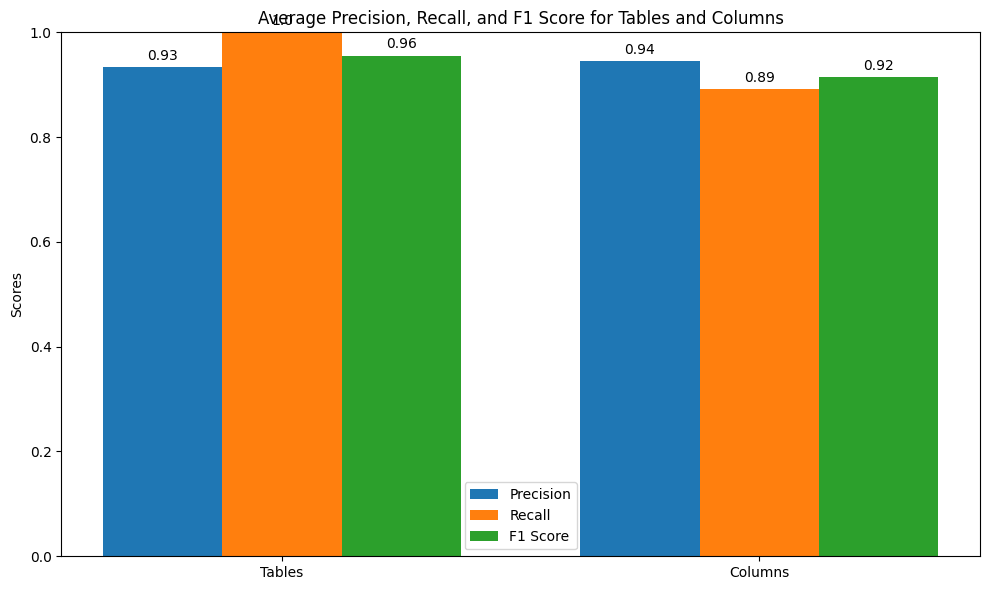

In [10]:
# aggregate the results over all the data 
aggregated_metrics = aggregate_metrics(evals)
print("Aggregated Metrics:", aggregated_metrics)

plot_metrics(aggregated_metrics)

In [6]:
def make_test(data, model, num_samples):
    res = []
    for index, sample in tqdm(enumerate(data)):
        task = create_task(sample)
        dp_path = os.getenv("DB_ROOT_PATH") + f"/{task.db_id}/{task.db_id}.sqlite"
        schema = get_db_schema(dp_path)

        ans = column_selection(task=task, retrieved_entities=retrieved_entities[index],
                               retrieved_context=retrieved_context[index], tentative_schema=schema, model=model,
                               num_samples=num_samples)
        res.append(ans)

    evals = []
    for i, schema in enumerate(res):
        pred = schema["selected_schema"]
        task = create_task(data[i])
        db_path = os.getenv("DB_ROOT_PATH") + f"/{task.db_id}/{task.db_id}.sqlite"
        gt = get_sql_columns_dict(db_path, task.SQL)
        evaluation = evaluate_schema(gt, pred)
        evals.append(evaluation)

    aggregated_metrics = aggregate_metrics(evals)
    print("Aggregated Metrics:", aggregated_metrics)

    plot_metrics(aggregated_metrics)



15it [07:20, 29.35s/it]


Aggregated Metrics: {'table_metrics': {'precision': 0.9333333333333333, 'recall': 0.9666666666666667, 'f1': 0.9333333333333332}, 'column_metrics': {'precision': 0.9230687830687831, 'recall': 0.9019047619047619, 'f1': 0.9094687447628625}}


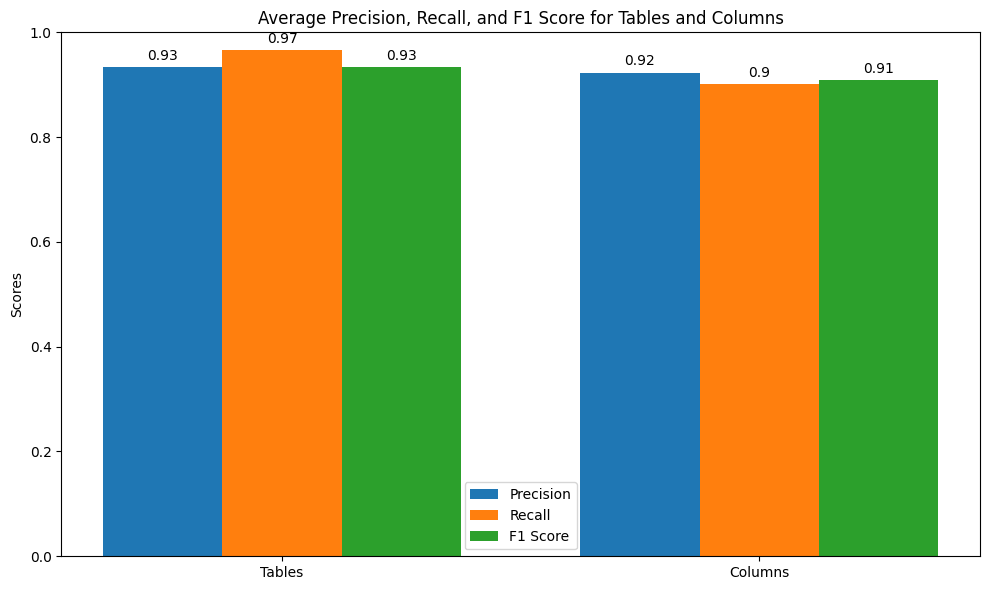

In [13]:
# test with gpt4 and with num_samples=3
model = "gpt-4"
num_samples = 3
make_test(data, model, num_samples)

# Comments : 
there is no big difference, so we will use just one sample to reduce cost and latency 
NB: these results are just on a small random sample which is not very efficient (Later on I will conduct those tests on the bigger sampled dev_set)

15it [00:51,  3.42s/it]


Aggregated Metrics: {'table_metrics': {'precision': 0.9555555555555556, 'recall': 0.9666666666666667, 'f1': 0.9444444444444444}, 'column_metrics': {'precision': 0.9172222222222223, 'recall': 0.6788095238095238, 'f1': 0.761902356902357}}


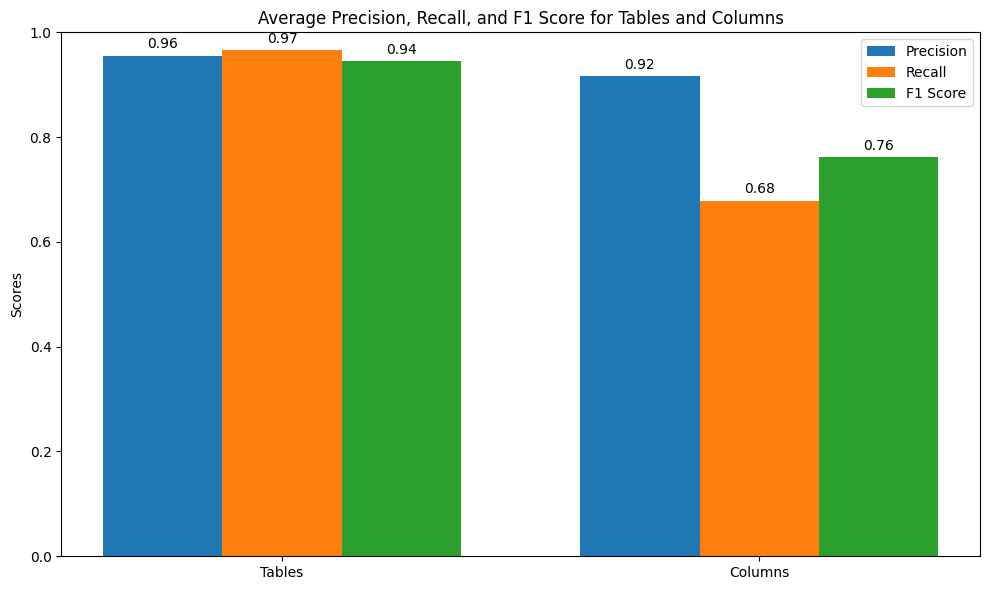

In [15]:
# test with gpt3.5
model = "gpt-3.5"
num_samples = 1
make_test(data, model, num_samples)

15it [01:16,  5.10s/it]


Aggregated Metrics: {'table_metrics': {'precision': 0.8833333333333333, 'recall': 0.9666666666666667, 'f1': 0.8911111111111112}, 'column_metrics': {'precision': 0.8466666666666668, 'recall': 0.8252380952380952, 'f1': 0.8254026256967434}}


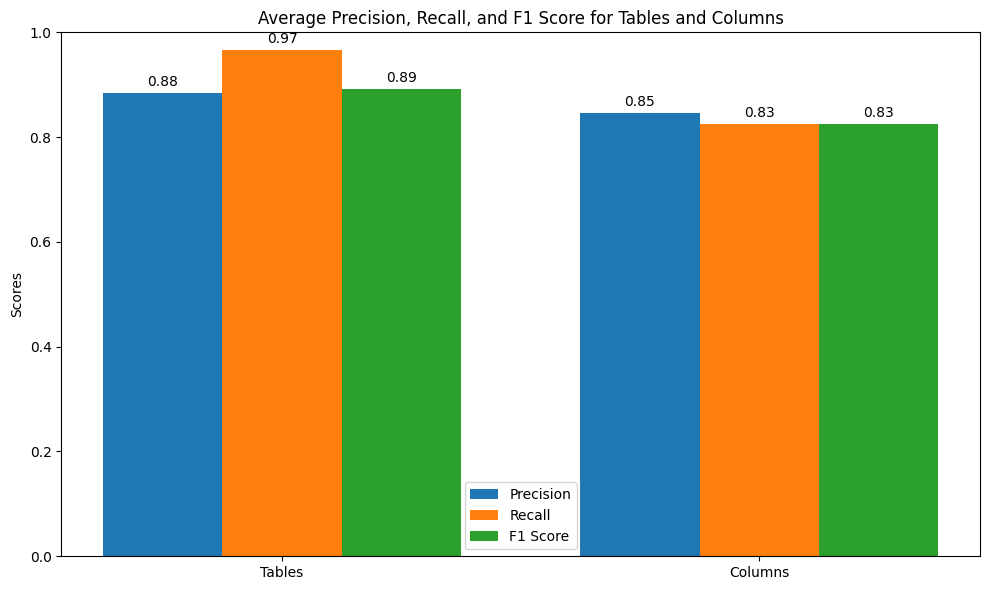

In [14]:
# test with open source Llama-3
model = "llama-3"
num_samples = 1
make_test(data, model, num_samples)

## Test after table selection 
 

In [9]:
def test(data, model, num_samples):
    res = []
    for index, sample in tqdm(enumerate(data)):
        task = create_task(sample)
        schema = tentative_schema[index]["tentative_schema"]
        ans = column_selection(task=task, retrieved_entities=retrieved_entities[index],
                               retrieved_context=retrieved_context[index], tentative_schema=schema, model=model,
                               num_samples=num_samples)
        res.append(ans)

    evals = []
    for i, schema in enumerate(res):
        pred = schema["selected_schema"]
        task = create_task(data[i])
        db_path = os.getenv("DB_ROOT_PATH") + f"/{task.db_id}/{task.db_id}.sqlite"
        gt = get_sql_columns_dict(db_path, task.SQL)
        evaluation = evaluate_schema(gt, pred)
        evals.append(evaluation)

    aggregated_metrics = aggregate_metrics(evals)
    print("Aggregated Metrics:", aggregated_metrics)

    plot_metrics(aggregated_metrics)


15it [02:37, 10.48s/it]


Aggregated Metrics: {'table_metrics': {'precision': 0.9666666666666667, 'recall': 1.0, 'f1': 0.9777777777777777}, 'column_metrics': {'precision': 0.9361111111111111, 'recall': 0.9164285714285715, 'f1': 0.9252849002849003}}


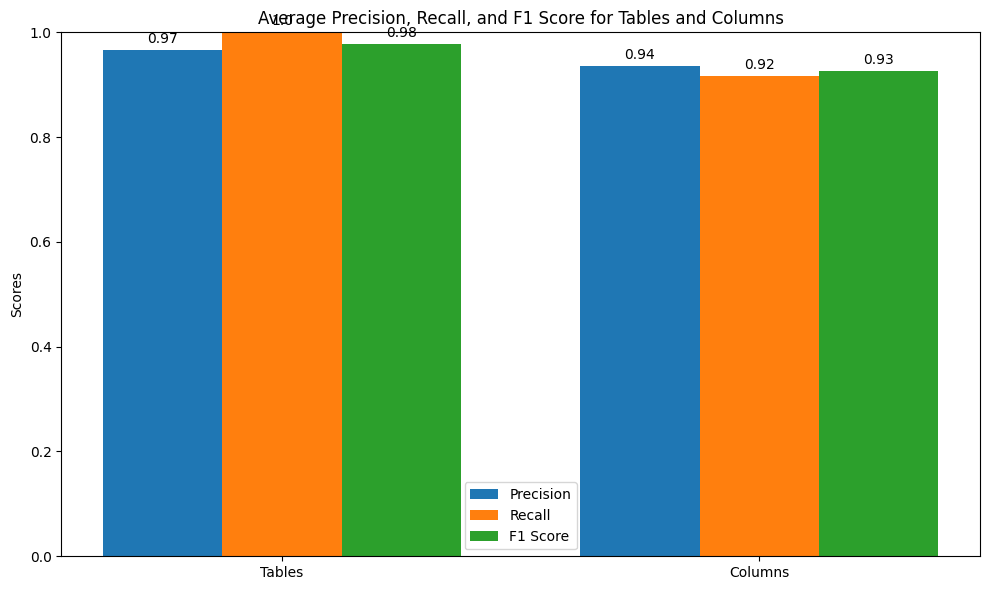

In [10]:
model = "gpt-4"
num_samples = 1
test(data, model, num_samples)

# Comments : 
there a small improvement in the results with table selection and after that column selection 
But still think that we can get a comparable results when merging the two in one prompt (because the difference not huge )


## Cost Estimation per task

In [6]:
PROMPT_PATH = os.getenv("PROMPT_ROOT_PATH") + "\column_selection.txt"
prompt = load_prompt(PROMPT_PATH)

In [7]:
def tokens_calc(example):
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(example))
    return num_tokens

In [8]:
#prompt template tokens 
tokens_calc(prompt)

483

The prompt template has 483 tokens in total, and we have also 3 other variables (Database_Schema,Question and Hint).
After i see a formatted prompt example it contains about 1800 tokens (because database_schema will be long)
So let's suppose that input tokens is 1800

In [9]:
## Output tokens estimation from an example 
output_example = """
{'selected_schema': {'frpm': ['CDSCode',
   'County Name',
   'Low Grade',
   'High Grade',
   'NSLP Provision Status'],
  'schools': ['CDSCode', 'City', 'EILCode', 'County']},
 'chain_of_thought_reasoning': "The question asks for the city location of a high school level school with Lunch Provision 2, lowest grade 9, and highest grade 12 in the county of Merced. The hint suggests that EILCode = 'HS' represents high school. We need to identify the school with this characteristic and then find its city location. We can filter the schools based on EILCode, County, Low Grade, and High Grade. We also need to join the frpm and schools tables to get the city location."}
"""
tokens_calc(output_example)

170

Let's suppose the number of tokens in the output is 200 

In [13]:
## Price calculation (just with gpt4 because in this module we don't use gpt3.5) 
input_price_per_token_gpt4 = 0.01 / 1000
output_price_per_token_gpt4 = 0.03 / 1000
price_gpt4 = 1800 * input_price_per_token_gpt4 + 200 * output_price_per_token_gpt4
print("estimated price per Task (GPT-4):", price_gpt4, "$")

estimated price per Task (GPT-4): 0.024 $


In [14]:
## in this module there is a number of retrials so let's estimate the price with different number of retrials 

num_retrials = [1, 2, 3, 4, 5]
for num_retrial in num_retrials:
    total_price = price_gpt4 * num_retrial
    print("The estimated price with number of retrials of " + str(num_retrial) + ": ", total_price)

The estimated price with number of retrials of 1:  0.024
The estimated price with number of retrials of 2:  0.048
The estimated price with number of retrials of 3:  0.07200000000000001
The estimated price with number of retrials of 4:  0.096
The estimated price with number of retrials of 5:  0.12


### Note that there is no huge difference between different num of retrials so we can stick to just one retrial